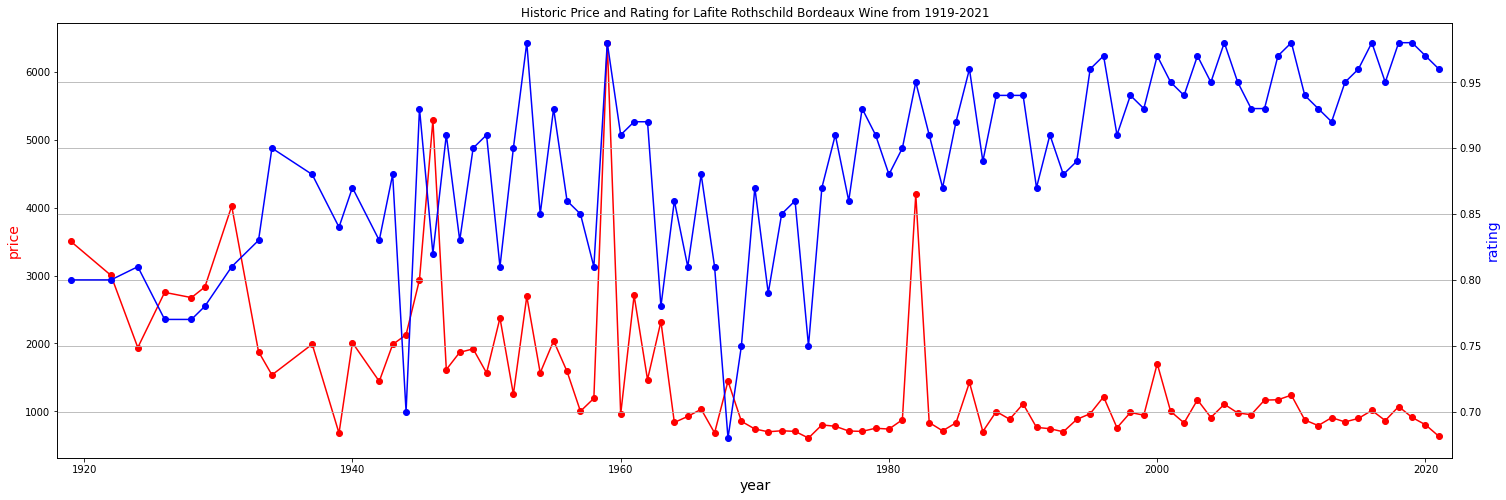

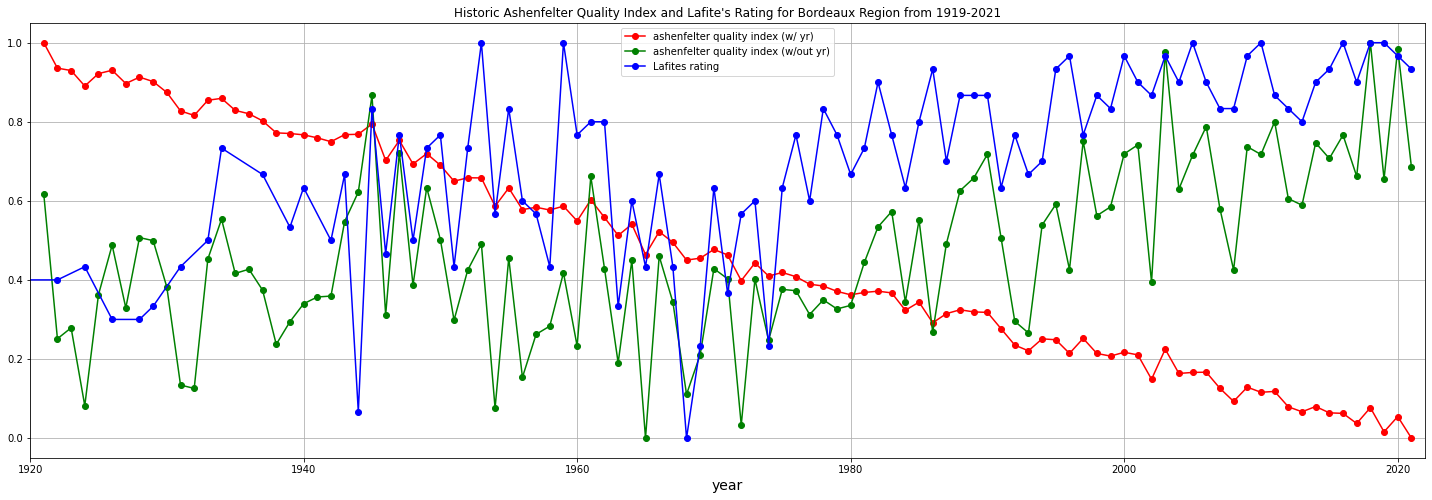

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

def ashenfelterQualityIndex2(avgTempGrowing, 
                            totalPrecipAug,
                            avgTempSept, 
                            totalPrecipWinter):
    return (.608*(avgTempGrowing) - .00380*(totalPrecipAug) + .00115*(totalPrecipWinter) + .00765*(avgTempSept))

def ashenfelterQualityIndex1(vintageYr,
                            avgTempGrowing, 
                            totalPrecipAug,
                            avgTempSept, 
                            totalPrecipWinter):

    return (.240*(2021-vintageYr) + .608*(avgTempGrowing) - .00380*(totalPrecipAug) + .00115*(totalPrecipWinter) + .00765*(avgTempSept))


df1 = pd.read_excel(r'C:/Users/polin/Dropbox/EE 608 spring 2023/project/Wine-Quality-Modeling/data/lafitePriceQuality.xlsx')
df1 = df1.iloc[::2]

Year = df1['year'].values
Price = df1['price'].values
Quality = df1['quality'].values
Index = []
for num in Quality:
    q = num.split('/') 
    Index.append(float(q[0])/float(q[1]))

fig,ax = plt.subplots()
fig.set_size_inches(25, 8)
ax.plot(Year, Price, color="red", marker="o")
ax.set_xlabel("year", fontsize = 14)
ax.set_ylabel("price", color="red", fontsize=14)
ax2 = ax.twinx()
ax2.plot(Year, Index,color="blue", marker="o")
ax2.set_ylabel("rating", color="blue", fontsize=14)
plt.xlim(1918, 2022)
plt.title("Historic Price and Rating for Lafite Rothschild Bordeaux Wine from 1919-2021")
plt.grid()
plt.show()

df2 = pd.read_excel(r'C:/Users/polin/Dropbox/EE 608 spring 2023/project/Wine-Quality-Modeling/data/bordeauxWeather.xlsx')
Year2 = df2['year'].values.tolist()
avgTempSept = df2['sepT'].values.tolist()
avgTempGrowing = df2['avgTempAprilSeptember'].values.tolist()
totalPrecipAug = df2['totalPSeptAug'].values.tolist()
totalPrecipWinter = df2['totalPOctMar'].values.tolist()

ashIndex1 = []
for idx, y in enumerate(Year2):
        ashIndex1.append(ashenfelterQualityIndex1(y, 
                                            avgTempGrowing[idx], 
                                            totalPrecipAug[idx], 
                                            avgTempSept[idx], 
                                            totalPrecipWinter[idx]))
ashIndex2 = []
for idx, y in enumerate(Year2):
        ashIndex2.append(ashenfelterQualityIndex2(avgTempGrowing[idx], 
                                            totalPrecipAug[idx], 
                                            avgTempSept[idx], 
                                            totalPrecipWinter[idx]))

# Normalize Ashenfelter Index (0-1)
ashIndex1 = (ashIndex1 - np.min(ashIndex1))/(np.max(ashIndex1) - np.min(ashIndex1))
# Normalize Ashenfelter Index (0-1)
ashIndex2 = (ashIndex2 - np.min(ashIndex2))/(np.max(ashIndex2) - np.min(ashIndex2))
# Normalize Lafite's Rating (0-1)
lafiteRating = (Index - np.min(Index))/(np.max(Index) - np.min(Index))


fig,ax = plt.subplots()
fig.set_size_inches(25, 8)

ax.plot(Year2, ashIndex1, color="red", marker="o")
ax.plot(Year2, ashIndex2 ,color="green", marker="o")
ax.plot(Year, lafiteRating,color="blue", marker="o")

ax.set_xlabel("year", fontsize = 14)
ax.legend(['ashenfelter quality index (w/ yr)', 'ashenfelter quality index (w/out yr)', 'Lafites rating'])


plt.xlim(1920, 2022)
plt.title("Historic Ashenfelter Quality Index and Lafite's Rating for Bordeaux Region from 1919-2021")
plt.grid()
plt.show()
